In [17]:
# 基于tensorflow的GoogLeNet代码实现
# inception块
#    超参数：输出通道数
#    填充参数均为 same
#    由四条线路构成，第一条：1 * 1 卷积层；第二层：1*1卷积层和3*3卷积层；第三层：1*1和5*5；第四层：3*3MaxPool，1*1卷积
import numpy as np
np.random.seed(0)
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# 定义inception类
class Inception(tf.keras.layers.Layer):
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        # 第一条
        self.p1 = tf.keras.layers.Conv2D(c1, kernel_size=1, padding='same', activation='relu')
        # 第二条
        self.p2_1 = tf.keras.layers.Conv2D(c2[0], kernel_size=1, padding='same', activation='relu')
        self.p2_2 = tf.keras.layers.Conv2D(c2[1], kernel_size=3, padding='same', activation='relu')
        # 第3条
        self.p3_1 = tf.keras.layers.Conv2D(c3[0], kernel_size=1, padding='same', activation='relu')
        self.p3_2 = tf.keras.layers.Conv2D(c3[1], kernel_size=5, padding='same', activation='relu')
        # 第4条
        self.p4_1 = tf.keras.layers.MaxPool2D(pool_size=3, padding='same', strides=1)
        self.p4_2 = tf.keras.layers.Conv2D(c4, kernel_size=1, padding='same', activation='relu')
    
    def call(self, X):
        p1 = self.p1(X)
        p2 = self.p2_2(self.p2_1(X))
        p3 = self.p3_2(self.p3_1(X))
        p4 = self.p4_2(self.p4_1(X))
        return tf.concat([p1, p2, p3, p4], axis=-1)

In [11]:
# GooLeNet模型， 包含5个模块 每个模块使用3*3 步幅为2的最大池化层
# 模块1: 64通道 7*7卷积层
b1 = tf.keras.models.Sequential()
b1.add(tf.keras.layers.Conv2D(64, kernel_size=7, padding='same', activation='relu'))
b1.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
# 模块2: 64通道1*1卷积，64*3通道 3*3卷积
b2 = tf.keras.models.Sequential()
b2.add(tf.keras.layers.Conv2D(64, kernel_size=1, padding='same', activation='relu'))
b2.add(tf.keras.layers.Conv2D(192, kernel_size=3, padding='same', activation='relu'))
b2.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
# 模块3：两个Iception块
b3 = tf.keras.models.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32))
b3.add(Inception(128, (128, 192), (32, 96), 64))
b3.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
# 模块4: 5个Inception块
b4 = tf.keras.models.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64))
b4.add(Inception(160, (112, 224), (24, 64), 64))
b4.add(Inception(128, (128, 256), (24, 64), 64))
b4.add(Inception(112, (144, 288), (32, 64), 64))
b4.add(Inception(256, (160, 320), (32, 128), 128))
b4.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
# 模块5：2个Inception加全局平均池化层将每个通道的高宽降为1
b5 = tf.keras.models.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128))
b5.add(Inception(384, (192, 384), (48, 128), 128))
b5.add(tf.keras.layers.GlobalAvgPool2D())
# 最后，将输出变成二维数组后接上一个输出个数为标签类别数的全连接层
GoogLeNet = tf.keras.models.Sequential([b1, b2, b3, b4, b5, tf.keras.layers.Dense(10, activation='sigmoid')])

In [12]:
# # 数据处理阶段，同AlexNet 使用fashion_mnist 将28 * 28 扩充为96*96
class DataLoad():
    def __init__(self):
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = fashion_mnist.load_data()
        self.train_images = np.expand_dims(self.train_images.astype(np.float32) / 255.0, axis=-1)
        self.test_images = np.expand_dims(self.test_images.astype(np.float32) / 255.0, axis=-1)
        self.train_labels = self.train_labels.astype(np.int32)
        self.test_labels = self.test_labels.astype(np.int32)
        self.train_num, self.test_num = self.train_images.shape[0], self.test_images.shape[0]
    
    def get_batch_train(self, batch_size):
        index = np.random.randint(0, self.train_num, batch_size)
        # 填充数据集变为96*96 tf.image
        train_batch = tf.image.resize_with_pad(self.train_images[index], 96, 96)
        return train_batch, self.train_labels[index]
    
    def get_batch_test(self, batch_size):
        index = np.random.randint(0, self.test_num, batch_size)
        # 填充数据集变为96*96 tf.image
        test_batch = tf.image.resize_with_pad(self.test_images[index], 96, 96)
        return test_batch, self.test_labels[index]

In [13]:
batch_size = 128

data_load  = DataLoad()

In [22]:
class Chart():
    def __init__(self):
        self.fig, self.ax = plt.subplots(1,2, figsize=(10, 20))
    
    def plot(self, loss, accuracy):
        self.ax[0].clear()
        self.ax[0].plot(loss)
        self.ax[0].set_xlabel('iteration')
        self.ax[0].set_ylabel('loss')
        self.ax[1].clear()
        self.ax[1].plot(accuracy)
        self.ax[1].set_xlabel('iteration')
        self.ax[1].set_ylabel('accuracy')
        self.fig.canvas.draw()

4/4 [==============================] - 0s 81ms/step - loss: 0.1658 - accuracy: 0.9453


4/4 [==============================] - 0s 81ms/step - loss: 0.1840 - accuracy: 0.9219


4/4 [==============================] - 0s 81ms/step - loss: 0.1785 - accuracy: 0.9453


4/4 [==============================] - 0s 81ms/step - loss: 0.1387 - accuracy: 0.9375


4/4 [==============================] - 0s 81ms/step - loss: 0.1849 - accuracy: 0.9375


4/4 [==============================] - 0s 81ms/step - loss: 0.2586 - accuracy: 0.8984


4/4 [==============================] - 0s 82ms/step - loss: 0.2023 - accuracy: 0.9297


4/4 [==============================] - 0s 82ms/step - loss: 0.1765 - accuracy: 0.9297


4/4 [==============================] - 0s 83ms/step - loss: 0.1809 - accuracy: 0.9297


4/4 [==============================] - 0s 82ms/step - loss: 0.1937 - accuracy: 0.9375


4/4 [==============================] - 0s 82ms/step - loss: 0.2005 - accuracy: 0.9297


4/4 [==============================] - 0s 81ms/step - loss: 0.1380 - accuracy: 0.9375


4/4 [==============================] - 0s 82ms/step - loss: 0.1759 - accuracy: 0.9141


4/4 [==============================] - 0s 82ms/step - loss: 0.1665 - accuracy: 0.9375


4/4 [==============================] - 0s 82ms/step - loss: 0.1390 - accuracy: 0.9531


4/4 [==============================] - 0s 81ms/step - loss: 0.1161 - accuracy: 0.9531


4/4 [==============================] - 0s 82ms/step - loss: 0.1958 - accuracy: 0.9141


4/4 [==============================] - 0s 81ms/step - loss: 0.0955 - accuracy: 0.9766


4/4 [==============================] - 0s 81ms/step - loss: 0.1273 - accuracy: 0.9453


4/4 [==============================] - 0s 81ms/step - loss: 0.1768 - accuracy: 0.9609


4/4 [==============================] - 0s 81ms/step - loss: 0.1983 - accuracy: 0.9297


4/4 [==============================] - 0s 81ms/step - loss: 0.1749 - accuracy: 0.9375


4/4 [==============================] - 0s 82ms/step - loss: 0.1919 - accuracy: 0.9297


4/4 [==============================] - 0s 82ms/step - loss: 0.1227 - accuracy: 0.9531


4/4 [==============================] - 0s 82ms/step - loss: 0.0965 - accuracy: 0.9609


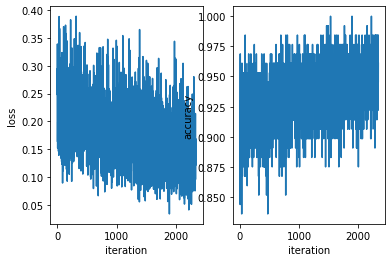

In [21]:
chart = Chart()
def train_GoogLeNet():
    loss = []
    accuracy = []
    epochs = 5
    num_iter = data_load.train_num // batch_size
    for _ in range(epochs):
        for t in range(num_iter):
            X_batch, Y_batch = data_load.get_batch_train(batch_size)
            history = GoogLeNet.fit(X_batch, Y_batch)
            loss.append(history.history['loss'])
            accuracy.append(history.history['accuracy'])
            chart.plot(loss, accuracy)
            if t % 20 == 0:
                GoogLeNet.save_weights('GoogLeNet_weights.h5')
    return loss, accuracy
# 优化器
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.06, momentum=0.1, nesterov=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
GoogLeNet.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
loss, accuracy = train_GoogLeNet()